In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
import string
import gensim
import pymorphy2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel

## Download data

In [ ]:
# with open('filename', 'r') as original: data = original.read()
# with open('filename', 'w') as modified: modified.write("new first line\n" + data)

In [5]:
with open('../data/music_collection/music.csv', 'r') as fin:
    data = fin.read().splitlines(True)

In [7]:
with open('../data/music_collection/music_artists_only.csv', 'w') as fout:
    fout.write(f'user_id,song_id,artist\n')
    for line in data:
        line = line.split(',')
        try:
            fout.write(f'{line[0]},{line[1]},{line[2]}\n')
        except:
            pass

In [8]:
music_df = pd.read_csv('../data/music_collection/music_artists_only.csv')

In [9]:
music_df

,user_id,song_id,artist
0,600048599,456239017,sozONik
1,1247454,456239029,Metallica
2,1247454,456239027,Metallica
3,1247454,456239026,Metallica
4,1247454,456239025,Metallica
...,...,...,...
299343,432185346,456239051,РВАТЬ НА БИТАХ
299344,432185346,456239050,MARKUL & OBLADAET
299345,432185346,456239048,Rickey F
299346,432185346,456239047,СТАРЫЙ


### Process data

In [12]:
music_df['artist'] = [str(artist).lower() for artist in music_df['artist']]

In [13]:
music_df

,user_id,song_id,artist
0,600048599,456239017,sozonik
1,1247454,456239029,metallica
2,1247454,456239027,metallica
3,1247454,456239026,metallica
4,1247454,456239025,metallica
...,...,...,...
299343,432185346,456239051,рвать на битах
299344,432185346,456239050,markul & obladaet
299345,432185346,456239048,rickey f
299346,432185346,456239047,старый


In [22]:
users = list(set(music_df['user_id']))
len(users)

2550

In [ ]:
music_with_duplicates = []
music_without_duplicates = []

for user_id in users:
    artists = music_df.loc[music_df['user_id'] == user_id]['artist'].values
    music_with_duplicates.append(' '.join(artists))
    music_without_duplicates.append(' '.join(list(set(artists))))

In [24]:
users_music_df = pd.DataFrame()
users_music_df['user_id'] = users
users_music_df['music_wo_d'] = music_without_duplicates
users_music_df['music_w_d'] = music_with_duplicates

In [25]:
users_music_df

,user_id,music_wo_d,music_w_d
0,NaN,,
1,4720602,зажигаем январь 2017 катя pompeya new age поли...,loboda new age полина лобода катя portugal. th...
2,1536048,олег митяев страсти по матфею (и.с. бах) м. и....,вадим шефнер машина времени itzhak perlman шар...
3,462440072,omid & thomas anders (modern talking) неизвест...,modern talking modern talking modern talking m...
4,537085,tiesto pres. steve forte rio feat. lindsey ray...,andy caldwell & michael teixeira feat. lisa do...
...,...,...,...
2545,116406640,филипп жарусски kitaro uma mohan андреа бочелл...,днепров анатолий филипп жарусски филипп жарусс...
2546,110914760,within temptation ber-linn neon genesis evange...,слава neon genesis evangelion евангелион кофе ...
2547,8128679,с днём рождения!!! и будь счастливой! леонид а...,елена воробей николай басков остров погибших к...
2548,286674714,виа спецназ альфа сбу diana diez & kostas mart...,олег янченко юрий гапуев янченко олег (брянск)...


### LDA model

Независимые данные об исполнителях

In [14]:
texts_list = [str(values).split() for values in music_df['artist']]

In [15]:
id2word = corpora.Dictionary(texts_list)

In [16]:
corpus = []
for text in texts_list:
    corpus.append(id2word.doc2bow(text))

In [17]:
# Пробная модель на независимых названиях исполнителей
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10, 
                                            random_state=42,
                                            update_every=1,
                                            chunksize=5000,
                                            passes=10,
                                            iterations=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [26]:
texts_list = [str(values).split() for values in users_music_df['music_wo_d']]

In [27]:
id2word = corpora.Dictionary(texts_list)

In [28]:
corpus = []
for text in texts_list:
    corpus.append(id2word.doc2bow(text))

In [29]:
perplexity_nouns_metrics = []
coherence_nouns_metrics = []

for topic_n in range(5,25,2):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=topic_n, 
                                            random_state=42,
                                            update_every=1,
                                            chunksize=5000,
                                            passes=10,
                                            iterations=10,
                                            alpha='auto',
                                            per_word_topics=True)
    
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_nouns_metrics.append(perplexity)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_list, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_nouns_metrics.append(coherence_lda)
    
    lda_model.save(f'music_lda_model_{topic_n}.model')
    print(topic_n)

5
7
9
11
13
15
17
19
21
23


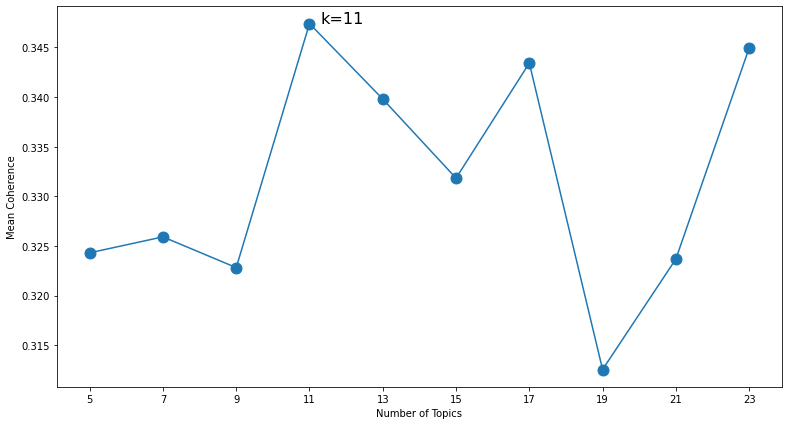

In [33]:
fig = plt.figure(figsize=(13, 7))

ax = plt.plot(list(range(5,25,2)), coherence_nouns_metrics)

plt.xticks(list(range(5,25,2)))
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

plt.scatter(list(range(5,25,2)), coherence_nouns_metrics, s=120)

ymax = max(coherence_nouns_metrics)
xpos = coherence_nouns_metrics.index(ymax)
best_k = list(range(5, 25, 2))[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

plt.show()

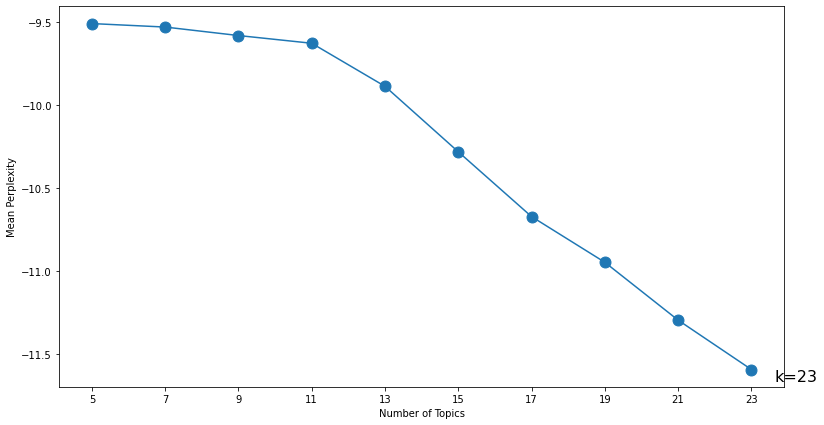

In [34]:
fig = plt.figure(figsize=(13,7))

ax = plt.plot(list(range(5,25,2)), perplexity_nouns_metrics)

plt.xticks(list(range(5,25,2)))
plt.xlabel("Number of Topics")
plt.ylabel("Mean Perplexity")

plt.scatter(list(range(5,25,2)), perplexity_nouns_metrics, s=120)

ymax = min(perplexity_nouns_metrics)
xpos = perplexity_nouns_metrics.index(ymax)
best_k = list(range(5,25,2))[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

plt.show()

### Visualization

In [35]:
lda_model = gensim.models.ldamodel.LdaModel.load('music_lda_model_23.model')

In [36]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.000932  0.289880       1        1  31.632591
5      0.203384  0.198233       2        1  15.564841
7     -0.050886  0.284610       3        1  14.211549
18     0.328470  0.106900       4        1  12.069006
6     -0.175356  0.260936       5        1  11.877567
13     0.073779  0.197833       6        1   5.183631
4      0.030614  0.099685       7        1   1.901667
15    -0.097317  0.088741       8        1   1.379900
3     -0.149252  0.009290       9        1   0.982132
9      0.141906 -0.046908      10        1   0.894811
8     -0.150631 -0.048368      11        1   0.783816
22     0.107106 -0.147505      12        1   0.597376
12    -0.015866 -0.040775      13        1   0.418429
19     0.050014 -0.070509      14        1   0.415993
0     -0.089504 -0.084548      15        1   0.358870
14     0.039368 -0.113828      16        1   0.334815
10    -0.013554 -0.157170      17        1   0.253118
21    -0.074290 -0.161780      18        1   0.249037
11     0.017861 -0.160337      19        1   0.244834
20    -0.080985 -0.127007      20        1   0.237052
1     -0.020794 -0.106794      21        1   0.161692
16    -0.039345 -0.148595      22        1   0.130224
17    -0.035654 -0.121982      23        1   0.117048, topic_info=          Term          Freq         Total Category  logprob  loglift
77           &  12805.000000  12805.000000  Default  30.0000  30.0000
92       feat.  13601.000000  13601.000000  Default  29.0000  29.0000
567          и   5964.000000   5964.000000  Default  28.0000  28.0000
9          the   5944.000000   5944.000000  Default  27.0000  27.0000
194         dj   5936.000000   5936.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
9488   патимат      0.298338     17.410457  Topic23  -7.6080   2.6837
775        чиж      0.303070    120.020363  Topic23  -7.5923   0.7689
10479   шамиль      0.291355     18.048740  Topic23  -7.6317   2.6241
12082   сказки      0.280209     71.995531  Topic23  -7.6707   1.2015
14358      (в.      0.270027      3.874619  Topic23  -7.7077   4.0867

[1667 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
32257      9  0.736180  "балагуры"
65213      9  0.915801    "голубые
45944     16  0.690399     "грусть
83801     10  0.755189         "из
65084     12  0.946278     "разный
...      ...       ...         ...
35852     12  0.731810           🎀
23949      1  0.259807           💕
23949      9  0.649518           💕
18359      3  0.068755           💢
18359      5  0.825061           💢

[4718 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 8, 19, 7, 14, 5, 16, 4, 10, 9, 23, 13, 20, 1, 15, 11, 22, 12, 21, 2, 17, 18])

In [18]:
# Пробная модель на независимых названиях исполнителей
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.419894 -0.050658       1        1  14.249505
5     -0.117818  0.314757       2        1  12.922865
9     -0.321089  0.240000       3        1  11.081896
2      0.264169 -0.270035       4        1  10.881631
0      0.388438 -0.054798       5        1  10.808694
7      0.321619  0.196820       6        1   9.944995
6      0.129369  0.362538       7        1   8.917309
8      0.029047 -0.382950       8        1   7.577911
1     -0.052873 -0.055756       9        1   6.876322
3     -0.220968 -0.299917      10        1   6.738873, topic_info=           Term          Freq         Total Category  logprob  loglift
150       feat.  17836.000000  17836.000000  Default  30.0000  30.0000
149           &  19580.000000  19580.000000  Default  29.0000  29.0000
161          dj  10579.000000  10579.000000  Default  28.0000  28.0000
437         the   8504.000000   8504.000000  Default  27.0000  27.0000
4             и   8023.000000   8023.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1604   савичева    228.884769    229.955658  Topic10  -5.2967   2.6926
503       billy    227.909047    228.979944  Topic10  -5.3010   2.6926
348     madonna    223.426497    224.497394  Topic10  -5.3208   2.6925
1495       eric    215.551468    216.622377  Topic10  -5.3567   2.6923
14267     ocean    214.401148    215.472088  Topic10  -5.3621   2.6923

[339 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
149       1  0.205203     &
149       2  0.628581     &
149       3  0.166185     &
7689      7  0.996322     (
38        4  0.999736     -
...     ...       ...   ...
665      10  0.998148  юлия
372       7  0.998550  юрий
3785      8  0.997138     я
3743      3  0.997153     ★
1164      8  0.997700     ♫

[310 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 10, 3, 1, 8, 7, 9, 2, 4])